In [72]:
import pandas as pd
import numpy as np
from os import path
import warnings
from PIL import Image
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline


In [73]:
pd.set_option("display.max_colwidth", 200) 
pd.set_option('display.max_columns', None)
pd.options.display.width=None
pd.options.display.max_columns = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [ ]:
# Below code helped to collect data from Meetup website information about different meetups

import pandas as pd
from requests_html import HTMLSession
import pyppdf.patch_pyppeteer
import re
import time

session = HTMLSession()

url = "https://www.meetup.com/find/events/?allMeetups=true&radius=Infinity&userFreeform=Edmond%2C+OK&mcId=z73003&mcName=Edmond%2C+OK&month=01&day={}&year=2019"
links = []
followLinks = []

def getUrl(url):
    r = session.get(url,verify=False)
    r.html.render()
    return r

def writeToFile ( inputs ):
    with open('collectData.csv','a') as f:
        f.write ( inputs )

def collectLinks():
    for date in range(1,31):
        for link in getUrl( url.format( str(date) ) ).html.absolute_links:
            print ( link )
            if any(re.findall(r'terms|facebook|twitter|youtube|instagram|events|help|topics|secure|accounts|medium', link, re.IGNORECASE)):
                followLinks.append(link)
            else:
                links.append ( link )
            #print(link.split('.')[1])
    print ( '---------- stage 1 completed ------------')
    with open('links.txt' , 'a') as f:
        for link in links:
            f.wirte ( link + '\n')

def parseLinks():
    with open('links.txt','r') as f:

        for link in f.readlines():
            print ( link )
            resp = getUrl(link )
            title = ''.join ( resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[1]/h1/a/text()') )
            location = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[2]/div/div/div[1]/ul/li/a/span/text()') )
            meetSize = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[2]/div/div/div[2]/ul/li[1]/a/span/text()') )
            meetType = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[2]/div/div/div[2]/ul/li[2]/span/div/span/span/text()') )
            meetOrg = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[2]/div/div/div[3]/div/div/div/div[2]/a/span[2]/text()') )
            meetOtherNo = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[1]/div/section/div/div[2]/div/div[2]/div/div/div[3]/div/div/div/div[2]/a/p/span/span[2]/text()') )
            meetDesc = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[4]/div/div/div/div[1]/section[1]/div/div/div/p[2]/text()') )
            meetEveName = ''.join (resp.html.xpath('/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[4]/div/div/div/div[1]/section[2]/div[2]/div[1]/div/div/div[1]/div/div/div/div[2]/a/text()') )
            meetEvenTime = ''.join (resp.html.xpath ( '/html/body/div[1]/div/div[2]/div[2]/div[3]/main/div[4]/div/div/div/div[1]/section[2]/div[2]/div[1]/div/div/div[1]/div/div/div/div[1]/time/span/span[1]/text()') )
            time.sleep(15)

            writeToFile ( link +'|'+title +'|'+location+'|'+ meetSize +'|'+  meetType +'|'+ meetOrg +'|'+ meetOtherNo +'|'+meetDesc +'|'+ meetEveName +'|'+ meetEvenTime +'\n'   )
            print ( '----------------------------------------------'  )

def collectOtherLinks():
    with open ( 'followLinks.csv', 'a') as f:
        for line in followLinks:
            f.write ( line + '\n' )

collectLinks()
#parseLinks()

with open ( 'followLinks.csv', 'a') as f:
    for line in followLinks:
        f.write ( line + '\n' )

In [4]:
m  = pd.read_csv ( r'/home/vamshi/scripts/collectData.csv' , 
                     sep='|' , error_bad_lines=False, names=[ 'link' , 'title' , 'location' , 'meetSize' , 'meetType' , 'meetOrg' , 'meetOtherNo' , 
                             'meetDesc' , 'meetEveName' ,'meetEvenTime' ])
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 10 columns):
link            359 non-null object
title           230 non-null object
location        230 non-null object
meetSize        230 non-null object
meetType        230 non-null object
meetOrg         230 non-null object
meetOtherNo     180 non-null object
meetDesc        230 non-null object
meetEveName     224 non-null object
meetEvenTime    224 non-null object
dtypes: object(10)
memory usage: 35.5+ KB



#  DataFixes



In [5]:


m['meetSize'] = m.meetSize.str.replace('members','')
m['meetEvenTime'] = m.meetEvenTime.str.slice(start=4)
m['state'] = m.location.str.slice(start=-2)
m['city'] = m.location.str.slice(stop=-4)
m['meetOtherNo'] = m.meetOtherNo.str.replace('other','').str.replace('others','')
m.meetSize.str.replace("''",'').str.replace(",",'').str.replace(" ",'').astype(float)
m['meetSize'] = m.meetSize.str.replace("''",'').str.replace(",",'').str.replace(" ",'').astype(float)
m['meetSize'] = m.meetSize.interpolate(method='values')
m['meetOtherNo'] = m.meetOtherNo.str.replace('s','').str.replace(' ','').astype(float).interpolate(method='values')
m['state'] = m.state.ffill()
m['city'] = m.city.ffill()
m['meetType'] = m.meetType.ffill()


# Which state has most meetup's

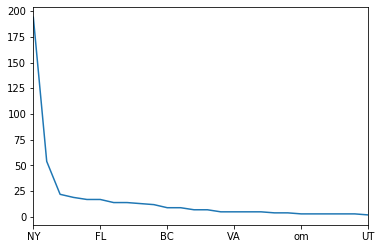

In [21]:
m.state.value_counts().plot()

# Which state highest number of people in meetup's

In [30]:
m[['state','meetSize']].groupby(['state','meetSize']).size()

state  meetSize
AB     4433.0      3
AZ     338.0       2
       614.0       1
       631.0       3
       638.5       2
                  ..
WI     317.0       3
       523.0       2
       571.0       4
nd     18458.0     4
om     248.0       3
Length: 105, dtype: int64

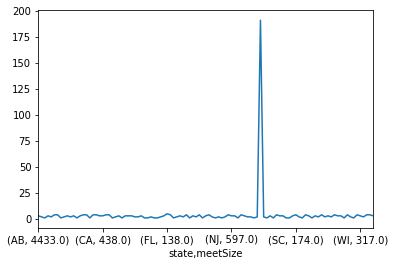

In [32]:
m[['state','meetSize']].groupby(['state','meetSize']).size().plot()

# most kind of meetup's

In [36]:
m.meetType.value_counts()

Public group     374
Private group     79
Name: meetType, dtype: int64

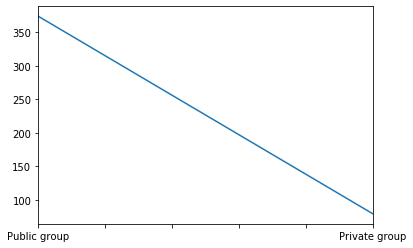

In [38]:
m.meetType.value_counts().plot()

# Wcich day has most meetups

In [86]:
m.meetEvenTime.value_counts().sort_index()

 - 15 miles       4
 Dec 19           6
 Dec 21           4
 Dec 25         178
 Dec 26           1
 Dec 27           1
 Dec 28           3
 Jan 1           22
 Jan 12           2
 Jan 7            3
Name: meetEvenTime, dtype: int64

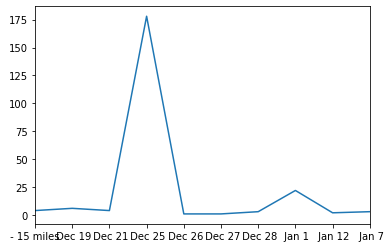

In [87]:
m.meetEvenTime.value_counts().sort_index().plot()

# Generate top 10 words used in title

In [54]:
m.title.dropna()

0              Diamond Bar & Walnut Soccer Sunday Meetup
1      Gut Check Fitness Outdoor Bootcamp Obstacle Co...
2                 HST Real Estate Investing Meetup Group
3      ORANGE PARK JACKSONVILLE Friends Social No Sho...
4             DESI OUTDOORS: Nature.Adventure.Experience
                             ...                        
258                        Startup Speakers Toastmasters
259                                  DINKs in Des Moines
261                                      Explore Myakka!
262                      Local Business Marketing Meetup
264      NY Beginners Real Estate Investing Meetup Group
Name: title, Length: 230, dtype: object

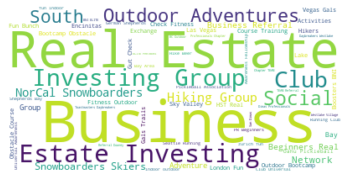

<Figure size 1440x1440 with 0 Axes>

In [78]:
text = " ".join(str(review) for review in m.title.dropna())
stopwords = set(STOPWORDS)
stopwords.update(["Meetup"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20,20))
plt.show()

# Generate top 10 words used in Description


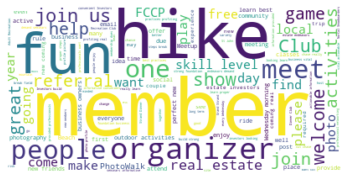

<Figure size 1440x1440 with 0 Axes>

In [82]:
text = " ".join(str(review) for review in m.meetDesc.dropna())
stopwords = set(STOPWORDS)
stopwords.update(["Meetup","event","member","group",'events','will'])

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20,20))
plt.show()

# Summary

1. NY has most meetup organized
2. There are more business related meetup's than social events
3. Meetup's are planned more in coming week and than further furture
4. Most meetup are public meetups
5. More meetups happen during public holidays